In [20]:
import hail as hl

In [21]:
import pandas as pd
import h5py
# import h5py_cache
import sys 
import numpy as np
sys.path.insert(0, '../code/')
from importlib import reload 
import my_hail_helper as myhelper

In [22]:
hl.init()

Running on Apache Spark version 2.4.1
SparkUI available at http://nucleus.cels.anl.gov:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.28-61941242c15d
LOGGING: writing to /vol/bmd/yanyul/GitHub/ptrs-ukb/notebook/hail-20191217-2128-0.2.28-61941242c15d.log


In [23]:
myhelper = reload(myhelper)

In [24]:
covar, trait = myhelper.read_and_split_phenotype_csv(
    csv_path = '/vol/bmd/yanyul/GitHub/ptrs-ukb/output/query_phenotypes_cleaned_up.csv',  # '/Users/yanyul/Documents/repo/github/ptrs-ukb/output/query_phenotypes_cleaned_up.csv',
    pheno_names = 'ht,meaning',
    covar_names = 'pc1',
    indiv_id = 'eid',
    int_names = None,
    str_names = 'meaning,eid'
)

In [25]:
indiv_list = myhelper.read_indiv_list('/vol/bmd/yanyul/GitHub/ptrs-ukb/output/data_split/British-test-1.txt')

In [26]:
trait_sub = myhelper.subset_by_col(trait, 'eid', indiv_list)

In [27]:
indiv_names_in_table = np.array(trait_sub['eid'].to_list()).astype('S10')

In [28]:
f = h5py.File(
    '/vol/bmd/yanyul/UKB/predicted_expression/predicted_expression.ukb_imp_x_ctimp_Whole_Blood.h5', 
    'r'
)

In [29]:
f.keys()

<KeysViewHDF5 ['genes', 'pred_expr', 'samples']>

In [30]:
nindiv = 20
ngene = 30
submat = f['pred_expr'][:ngene, :nindiv]
submat[3,:] = 0
subgene = f['genes'][:ngene]
subindiv = f['samples'][:nindiv]
hf = h5py.File('test_output/test_pred_expr.h5', 'w')
hf.create_dataset('genes', data = subgene)
hf.create_dataset('samples', data = subindiv)
hf.create_dataset('pred_expr', data = submat)
hf.close()
o = open('test_output/test_indiv.txt', 'w')
o.write('IID\n')
for i in subindiv[[1,3,5,7]].astype(str):
    o.write(i + '\n')
o.close()

In [31]:
submat[9,[1,3,5,7]]
# subgene[9]

array([-0.558185  , -1.1591849 , -0.59358495, -1.192285  ], dtype=float32)

In [32]:
!ls test_output

gcta_analysis.bm
gwas_subset_1_x_ht.tsv
gwas_subset_1_x_mch.tsv
gwas_subset_1_x_mcv.tsv
gwas_subset_2_x_ht.tsv
gwas_subset_2_x_mch.tsv
gwas_subset_2_x_mcv.tsv
pred_expr_british_test.tsv
run_prepare_phenotype_and_run_gwas.log
run_prepare_phenotype_and_run_gwas-with_variant_qc.log
test.grm.gz
test.grm.id
test_indiv.txt
test.pheno
test_pred_expr.h5


In [33]:
col_names = f['samples'][:]; target_names = indiv_names_in_table
col_names = np.array(col_names)
target_names = np.array(target_names)
target_idx = np.where(np.isin(col_names, target_names))[0]

In [34]:
target_idx

array([     1,      2,    129, ..., 487178, 487283, 487306])

In [53]:
from scipy.stats import norm
def extract_cols(h5mat, col_names, target_names):
    col_names = np.array(col_names)
    target_names = np.array(target_names)
    target_idx = np.where(np.isin(col_names, target_names))[0].flatten().tolist()
    subcols = col_names[target_idx]
    submat = h5mat[:, target_idx]
    return submat, subcols
def remove_constant_row(mat):
    std = np.std(mat, axis = (1))
    return mat[std != 0, :]
def inv_norm_row(mat):
    return np.apply_along_axis(standardize_vec, 1, mat)
def standardize_vec(vec, offset = 1):
    rank = myrank(vec)
    return norm.ppf(rank / (len(rank) + offset), loc = 0, scale = 1)
def myrank(vec):
    argsort = np.argsort(vec)
    ranks = np.empty_like(argsort)
    ranks[argsort] = np.arange(len(vec))
    return ranks + 1  # rank starts from 1
def format_to_gcta_grm(mat):
    nobs = mat.shape[0]
    nindiv = mat.shape[1]
    grm = np.dot(mat.transpose(), mat) / nobs
#     row_index = [ i for j in range(nindiv - i) for i in range(nindiv) ]  # 0-base
#     col_index = [ j for j in range(i, nindiv) for i in range(nindiv) ]  # 0-base
    indices = np.tril_indices(nindiv)
    grm_values = grm[indices]
    nobs_vec = np.ones(grm_values.shape[0]) * nobs
    df = pd.DataFrame({'idx1': indices[0] + 1, 'idx2': indices[1] + 1, 'nobs': nobs_vec.astype(int), 'gr': grm_values})
    return df

In [36]:
sub_pred_expr, sub_indivs = extract_cols(f['pred_expr'], f['samples'][:], indiv_names_in_table)

In [37]:
sub_pred_expr = remove_constant_row(sub_pred_expr)

In [54]:
inv_norm_sub_pred_expr = inv_norm_row(sub_pred_expr)

In [163]:
grm = format_to_gcta_grm(inv_norm_sub_pred_expr)
grm.to_csv('test_output/test.grm.gz', header = None, index = None, sep = '\t', compression = 'gzip')

In [131]:
pd.DataFrame({1:sub_indivs.astype('str'), 2:sub_indivs.astype('str')}).to_csv('test_output/test.grm.id', header = None, index = None, sep = '\t')

In [164]:
trait_sub[['eid', 'eid', 'ht']].to_csv('test_output/test.pheno', header = None, index = None, sep = '\t')

In [157]:
!ls

chr22_test.mt
first_attempt_on_hail.ipynb
first_attempt_on_hail.output.ht
first_attempt_on_hail.output.tsv.gz
hail-20191206-1337-0.2.28-61941242c15d.log
hail-20191206-1405-0.2.28-61941242c15d.log
hail-20191206-1525-0.2.28-61941242c15d.log
hail-20191206-1606-0.2.28-61941242c15d.log
hail-20191206-1712-0.2.28-61941242c15d.log
hail-20191206-1718-0.2.28-61941242c15d.log
hail-20191206-1721-0.2.28-61941242c15d.log
hail-20191206-1726-0.2.28-61941242c15d.log
hail-20191206-1735-0.2.28-61941242c15d.log
hail-20191206-1756-0.2.28-61941242c15d.log
hail-20191206-2039-0.2.28-61941242c15d.log
hail-20191206-2351-0.2.28-61941242c15d.log
hail-20191207-1057-0.2.28-61941242c15d.log
hail-20191208-0938-0.2.28-61941242c15d.log
hail-20191208-1020-0.2.28-61941242c15d.log
hail-20191208-1138-0.2.28-61941242c15d.log
hail-20191208-1306-0.2.28-61941242c15d.log
hail-20191208-1313-0.2.28-61941242c15d.log
hail-20191208-1347-0.2.28-61941242c15d.log
hail-20191208-1454-0.2.28-61941242c15d.log
hail-20191208-1500-0.2.28-6194

In [41]:
import seaborn as sns

In [49]:
inv_norm_sub_pred_expr.shape

(7041, 5000)

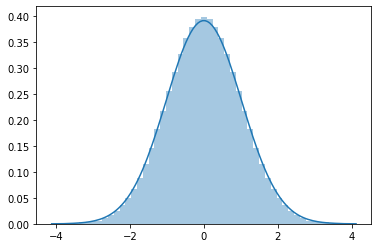

In [52]:
sns.distplot(inv_norm_sub_pred_expr[0,:])

In [75]:
np.mean(standardize_vec(np.array(range(1,10000))))

0.0

In [15]:
# f['pred_expr'][1:100].shape
# np.array([i for i in range(10)])[::5]
list(subset_idx_for_indiv_in_sub_table[0])

[1,
 2,
 129,
 344,
 353,
 455,
 475,
 840,
 923,
 1003,
 1012,
 1099,
 1302,
 1394,
 1646,
 1841,
 2155,
 2257,
 2285,
 2677,
 2911,
 3035,
 3136,
 3161,
 3167,
 3226,
 3232,
 3250,
 3302,
 3312,
 3386,
 3395,
 3442,
 3707,
 3747,
 4018,
 4180,
 4192,
 4260,
 4262,
 4351,
 4397,
 4570,
 4579,
 4752,
 4825,
 4838,
 4867,
 4944,
 4986,
 5055,
 5534,
 5543,
 5784,
 5813,
 5827,
 5903,
 5973,
 6316,
 6378,
 6423,
 6669,
 6685,
 7013,
 7393,
 7484,
 7499,
 7545,
 7640,
 7815,
 7846,
 7992,
 8011,
 8071,
 8073,
 8160,
 8208,
 8239,
 8309,
 8454,
 8585,
 8596,
 8686,
 8730,
 8738,
 8791,
 8909,
 8957,
 8958,
 9300,
 9376,
 9378,
 9825,
 9910,
 9933,
 10063,
 10286,
 10313,
 10495,
 10546,
 10606,
 10680,
 10734,
 10754,
 10795,
 11169,
 11265,
 11455,
 11503,
 11519,
 11524,
 11705,
 11932,
 12002,
 12021,
 12149,
 12237,
 12359,
 12382,
 12541,
 12597,
 12681,
 12948,
 12962,
 13002,
 13150,
 13172,
 13206,
 13247,
 13420,
 13486,
 13513,
 13659,
 13674,
 13823,
 14071,
 14114,
 14179,
 142

In [16]:
# pred_mat_sub = f['pred_expr'][:, list(subset_idx_for_indiv_in_sub_table[0])]  #

In [17]:
samples_sub = f['samples'][list(subset_idx_for_indiv_in_sub_table[0])]

In [18]:
# pred_mat_sub[pred_mat_sub.sum(axis = 1) != 0,:].shape

In [19]:
# genes_sub = f['genes'][pred_mat_sub.sum(axis = 1) != 0]

In [20]:
# pred_mat_sub = pred_mat_sub[pred_mat_sub.sum(axis = 1) != 0,:]

In [21]:
# df = pd.DataFrame(pred_mat_sub[pred_mat_sub.sum(axis = 1) != 0,:])

In [22]:
# df.columns = samples_sub.astype('str')
# df.index = genes_sub.astype('str')

In [23]:
# df['gene'] = df.index
# df = df.reset_index(drop = True)

In [24]:
# df.to_csv('test_output/pred_expr_british_test.tsv', index = None, header = True, sep = '\t')

NameError: name 'df' is not defined

In [25]:
type_dic = {
    i: hl.tfloat for i in samples_sub.astype('str')
}
type_dic['gene'] = hl.tstr

In [26]:
test = hl.import_table('test_output/pred_expr_british_test.tsv', types = type_dic)

2019-12-16 14:44:23 Hail: INFO: Reading table with no type imputation
  Loading column '5595764' as type 'float64' (user-specified)
  Loading column '5172041' as type 'float64' (user-specified)
  Loading column '1528789' as type 'float64' (user-specified)
  Loading column '1517276' as type 'float64' (user-specified)
  Loading column '2468738' as type 'float64' (user-specified)
  Loading column '4556757' as type 'float64' (user-specified)
  Loading column '1484605' as type 'float64' (user-specified)
  Loading column '4185318' as type 'float64' (user-specified)
  Loading column '2261357' as type 'float64' (user-specified)
  Loading column '1221294' as type 'float64' (user-specified)
  Loading column '5010377' as type 'float64' (user-specified)
  Loading column '2778295' as type 'float64' (user-specified)
  Loading column '5253976' as type 'float64' (user-specified)
  Loading column '4126923' as type 'float64' (user-specified)
  Loading column '5169018' as type 'float64' (user-specified)


  Loading column '3012783' as type 'float64' (user-specified)
  Loading column '3476491' as type 'float64' (user-specified)
  Loading column '1979045' as type 'float64' (user-specified)
  Loading column '1905902' as type 'float64' (user-specified)
  Loading column '3586776' as type 'float64' (user-specified)
  Loading column '3560724' as type 'float64' (user-specified)
  Loading column '1390472' as type 'float64' (user-specified)
  Loading column '2422542' as type 'float64' (user-specified)
  Loading column '2611815' as type 'float64' (user-specified)
  Loading column '1052457' as type 'float64' (user-specified)
  Loading column '1026399' as type 'float64' (user-specified)
  Loading column '2658333' as type 'float64' (user-specified)
  Loading column '3564909' as type 'float64' (user-specified)
  Loading column '4976978' as type 'float64' (user-specified)
  Loading column '1345640' as type 'float64' (user-specified)
  Loading column '2246070' as type 'float64' (user-specified)
  Loadin

  Loading column '4917191' as type 'float64' (user-specified)
  Loading column '4746210' as type 'float64' (user-specified)
  Loading column '4639496' as type 'float64' (user-specified)
  Loading column '5300749' as type 'float64' (user-specified)
  Loading column '3266154' as type 'float64' (user-specified)
  Loading column '4301492' as type 'float64' (user-specified)
  Loading column '2326971' as type 'float64' (user-specified)
  Loading column '3583180' as type 'float64' (user-specified)
  Loading column '4864298' as type 'float64' (user-specified)
  Loading column '2499780' as type 'float64' (user-specified)
  Loading column '5964006' as type 'float64' (user-specified)
  Loading column '1141530' as type 'float64' (user-specified)
  Loading column '2338450' as type 'float64' (user-specified)
  Loading column '4872521' as type 'float64' (user-specified)
  Loading column '3247825' as type 'float64' (user-specified)
  Loading column '3050111' as type 'float64' (user-specified)
  Loadin

  Loading column '5802224' as type 'float64' (user-specified)
  Loading column '1452440' as type 'float64' (user-specified)
  Loading column '2638012' as type 'float64' (user-specified)
  Loading column '4442394' as type 'float64' (user-specified)
  Loading column '4759900' as type 'float64' (user-specified)
  Loading column '5961388' as type 'float64' (user-specified)
  Loading column '1437822' as type 'float64' (user-specified)
  Loading column '5307037' as type 'float64' (user-specified)
  Loading column '5861509' as type 'float64' (user-specified)
  Loading column '4141988' as type 'float64' (user-specified)
  Loading column '1790675' as type 'float64' (user-specified)
  Loading column '5983180' as type 'float64' (user-specified)
  Loading column '3333659' as type 'float64' (user-specified)
  Loading column '5783174' as type 'float64' (user-specified)
  Loading column '5130889' as type 'float64' (user-specified)
  Loading column '3941641' as type 'float64' (user-specified)
  Loadin

In [27]:
mttest = test.key_by('gene').to_matrix_table_row_major(columns = list(samples_sub.astype('str')), entry_field_name = 'pred_expr', col_field_name = 's')

In [28]:
mttest = mttest.repartition(40)

In [29]:
mttest.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'gene': str
----------------------------------------
Entry fields:
    'pred_expr': float64
----------------------------------------
Column key: ['s']
Row key: ['gene']
----------------------------------------


In [30]:
trait = myhelper.df_to_ht(trait.rename(columns = {'eid' : 's'}), 's')

2019-12-16 14:44:50 Hail: INFO: Ordering unsorted dataset with network shuffle


In [31]:
covar = myhelper.df_to_ht(covar.rename(columns = {'eid' : 's'}), 's')

2019-12-16 14:45:01 Hail: INFO: Ordering unsorted dataset with network shuffle


In [32]:
mttest = mttest.annotate_cols(trait = trait[mttest.s], covar = covar[mttest.s])

In [33]:
mttest.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'trait': struct {
        ht: float64, 
        meaning: str
    }
    'covar': struct {
        pc1: float64
    }
----------------------------------------
Row fields:
    'gene': str
----------------------------------------
Entry fields:
    'pred_expr': float64
----------------------------------------
Column key: ['s']
Row key: ['gene']
----------------------------------------


In [34]:
model, p = hl.linear_mixed_model(
    y = mttest.trait.ht,
    x = [1] + [ mttest.covar[i] for i in list(mttest.covar.keys())],
    z_t = mttest.pred_expr,
    p_path = 'test_output/gcta_analysis.bm',
    overwrite = True
)

2019-12-16 14:46:19 Hail: INFO: Coerced sorted dataset
2019-12-16 14:46:50 Hail: INFO: Wrote all 4 blocks of 7041 x 5000 matrix with block size 4096.
2019-12-16 14:47:23 Hail: INFO: wrote matrix with 5000 rows and 5000 columns as 4 blocks of size 4096 to test_output/gcta_analysis.bm


In [35]:
model.fit()

In [36]:
model.h_sq

0.02798538837315062